# <center>Часть 3. Прогнозирование ряда со сложной сезонностью

Основная сложность работы с такими рядами, как в нашем проекте, заключается в том, **как учесть сложную структуру сезонности** — суточной, недельной и годовой. В рамках моделей ARIMA можно учесть **только одну** из них. Обычно в таких случаях сезонность с самым **маленьким** периодом явно моделируют с помощью аримы, а все остальные учитывают за счёт регрессионной компоненты.

Для учёта недельной сезонности используются регрессионные признаки следующего вида:

$$s_i=sin([1,…,T]∗2πi/168), c_i=cos([1,…,T]∗2πi/168), i=1,…,K.$$
    
Здесь T — это длина моделируемого ряда, 168 — длительность недели в часах, а значение параметра K вам предстоит подобрать самостоятельно (в зависимости от длины подготовленного ряда, можно для начала взять $K$ равным $2-5$).

Если учитывать данные за несколько лет, аналогичные признаки можно использовать для учёта годовой сезонности. Длина года — 8766 часов.

Если в данных есть линейный или описываемый ещё какой-то простой функцией $f$ тренд, стоит добавить к регрессионным признакам вектор $[1,…,T]$ или, соответственно, $f([1,…,T])$.

Для освежения в памяти, как в **statsmodels** работать с моделями **ARIMA**, можно почитать [туториал](https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/statespace_sarimax_stata.ipynb) от создателей.

## План.

1. Выберем **одну из зон** среди отобранных на прошлой неделе, взять по ней все подготовленные данные о количестве поездок. (Не использовать данные за последний имеющийся месяц — июнь 2016!). Создадим **регрессионные признаки** для учёта сезонностей и трендов.
2. Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделаем регрессию целевого признака — количества поездок — на построенные признаки. Посмотрим на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вряд ли удастся, так что в остатках, скорее всего, будет много интересного, в том числе праздники, аномалии, тренды и многое другое.
3. Чтобы подобрать значения гиперпараметров ARIMA, попробуем сделать ряд остатков **стационарным**. Если необходимо, сделаем несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируемся в первую очередь на результат STL-декомпозиции.
4. Построим **ACF** и **PACF** полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберем по ним начальные приближения для параметров **p,q,P,Q**. Используем эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра **exog**.
5. Выберем оптимальную по AIC модель; построим график исходного ряда и нарисуем поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуем увеличить количество синусов и косинусов K или поменять порядки дифференцирования.
6. Проанализируем качество построенной модели. Опишем, в какие периоды она плохо описывает данные. Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуем создать для таких периодов регрессионные признаки и вернемся к пункту 2.

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
from datetime import datetime
from pandas.tseries.offsets import Day

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
%matplotlib inline

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [2]:
from sklearn import linear_model

In [3]:
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy as sc
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from itertools import product
import warnings

C:\Users\dsher\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
from numpy.linalg import LinAlgError

In [5]:
path_to_data = 'C:\\Users\dsher\Documents\BIGDATA\sales_prediction_(yellow_taxi)'

## 1) Подготовка данных
- Выберем одну из зон среди отобранных в прошлой части, возьмем по ней все подготовленные данные о количестве поездок. 
- Для минимизации времени возьмем период первого полугодия 2016 года
- Не будем использовать данные за июнь 2016 (это будет тестовый месяц) 
- Создадим регрессионные признаки для учёта сезонностей и трендов

#### 1.1) Для начала обработаем все имеющиеся данные с использованием функции, созданной в Части 1, и создадим агрегированные данные по каждому имеющемуся месяцу

In [6]:
def data_preprocessing(path_to_file, path_to_data=path_to_data, output_file_prefix='aggdata'):
    '''
    Эта функция получает на вход путь к файлу с данными за месяц, после чего формирует и записывает 
    агрегированные по часам и областям данные в csv-файл с названием типа 'aggdata_2016-05.csv'
    '''
    
    
    data = pd.read_csv(path_to_file, 
                       usecols=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 
                            'trip_distance', 'pickup_longitude', 'pickup_latitude'], # оставим только нужные колонки
                   parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
    
    # границы Нью-Йорка
    west_bound = -74.25559
    east_bound = -73.70001
    south_bound = 40.49612
    north_bound = 40.91553
    
    # фильтруем данные от выбросов и некорректностей
    drop_indexes = data[(data['tpep_dropoff_datetime'] == data['tpep_pickup_datetime']) | 
                    (data['passenger_count'] == 0) | 
                    (data['trip_distance'] == 0) | 
                    (west_bound > data['pickup_longitude']) | (data['pickup_longitude'] > east_bound) | 
                    (south_bound > data['pickup_latitude']) | (data['pickup_latitude'] > north_bound)].index
    data.drop(drop_indexes, inplace=True)
    
    # отбрасываем минуты и секунды (округляем вниз до часов)
    data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].dt.floor('h')
    
    # оставляем только нужные колонки (освобождаем память)
    data = data[['tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude']]
        
    # --------------------------------------------------------------------------
    def count_statistic(df, col1='pickup_longitude', col2='pickup_latitude'):
        '''
        агрегируем данные в Датафрейме по времени (по часам), берем поле statistic (оно получилось 50х50) и вытягиваем его
        '''
        ret = binned_statistic_2d(df[col1], df[col2], None, 'count', bins=50, 
                                  range=[[west_bound, east_bound], [south_bound, north_bound]])
        return ret.statistic.astype(int).ravel()
    # --------------------------------------------------------------------------    
    def to_df(s):
        '''
        преобразовываем в датафрейм, в котором названия колонок - идентификаторы ячеек (str)
        ''' 
        df = pd.DataFrame.from_records(s.values, index=s.index, columns=(np.arange(2500) + 1).astype(str))
        return df
    # --------------------------------------------------------------------------    
    def control_timeindex(aggdata, month):
        '''
        Добавляет недостающие временные метки-индексы (если они есть) и заполняет пустоты нулями.
        Эта функция - на всякий случай (для контроля), если вдруг есть пропуски в индексе - временном ряде.
        
        month - str, текущий год и месяц (пример - '2016-05')
        '''
        start = month
        end = (datetime.strptime(start, '%Y-%m') + MonthBegin()).strftime('%Y-%m') # конечная дата через месяц
        
        ind = pd.date_range(start, end, freq='H')[:-1] # полный временной ряд (без последнего лишнего значения)
        
        # ИТОГО - дополнительный датафрейм с нулями заведомо "правильной" конфигурации, без пропусков:
        df = pd.DataFrame(np.zeros((len(ind), 2500)), index=ind, columns=(np.arange(2500) + 1).astype(str)) 
        df.index.name = 'tpep_pickup_datetime'
        
        # складываем его с основным датафреймом (в пропусках - наны, которые мы заполняем)
        df = (aggdata + df).fillna(0).astype(int)
        
        return df
    # --------------------------------------------------------------------------
    month = path_to_file[-11:-4] # вытягивам из названия текущий месяц
    
    # агрегируем данные    
    aggdata = control_timeindex(to_df(data.groupby('tpep_pickup_datetime').apply(count_statistic)), month)
    
    # записываем сформированный файл
    aggdata.to_csv(os.path.join(path_to_data, output_file_prefix + '_' + month + '.csv'))
    
    pass

Переберем все имеющиеся файлы для создания агрегированных данных (для минимизации времени возьмем по минимуму - 6 месяцев).   
Будем использовать библиотеку **glob**:

#### 1.2) Выберем ячейку

In [7]:
# функция для загрузки агрегированных данных
def read_aggdata(file_name):
    return pd.read_csv(os.path.join(path_to_data, file_name), index_col=0, parse_dates=True)

In [8]:
aggdata = read_aggdata('aggdata_2016-05.csv')
regions = pd.read_csv(os.path.join(path_to_data, 'regions.csv'), sep=';')
regions['rate'] = aggdata.sum().values
regions['avr_hour_rate'] = regions['rate'] /31. /24.
regions_more_5 = regions[regions['avr_hour_rate'] >= 5].region.values
regions_more_5

array([1075, 1076, 1077, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132,
       1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182,
       1183, 1184, 1221, 1222, 1223, 1224, 1225, 1227, 1228, 1229, 1230,
       1231, 1232, 1233, 1234, 1235, 1272, 1273, 1274, 1278, 1279, 1280,
       1281, 1282, 1283, 1284, 1285, 1286, 1287, 1326, 1327, 1331, 1332,
       1333, 1334, 1335, 1336, 1337, 1338, 1339, 1376, 1377, 1378, 1380,
       1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1426, 1431,
       1434, 1435, 1436, 1437, 1438, 1439, 1441, 1442, 1480, 1482, 1483,
       1530, 1532, 1533, 1580, 1630, 1684, 1733, 1734, 1783, 2068, 2069,
       2118, 2119, 2168], dtype=int64)

Будем использовать ячейку **1075**

In [9]:
selected_cell = '1075'

#### 1.3) Создадим временной ряд для моделирования прогнозов из имеющихся данных.   
Это будут данные из **selected_cell = 1075** за 5 первых месяцев 2016 года

In [10]:
data = pd.DataFrame()
for path_to_file in tqdm_notebook(sorted(glob(os.path.join(path_to_data, 'aggdata_*.csv')))):
    if os.path.basename(path_to_file) == 'aggdata_2016-06.csv':
        continue
    aggdata = read_aggdata(os.path.basename(path_to_file))
    data = pd.concat([data, aggdata[[selected_cell]]])

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [11]:
data.head()

,1075
tpep_pickup_datetime,
2016-01-01 00:00:00,80
2016-01-01 01:00:00,91
2016-01-01 02:00:00,90
2016-01-01 03:00:00,32
2016-01-01 04:00:00,24


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3648 entries, 2016-01-01 00:00:00 to 2016-05-31 23:00:00
Data columns (total 1 columns):
1075    3648 non-null int64
dtypes: int64(1)
memory usage: 57.0 KB


#### 1.4.) Создадим регрессионные признаки для учёта сезонностей и трендов

Посмотрим визуально на график

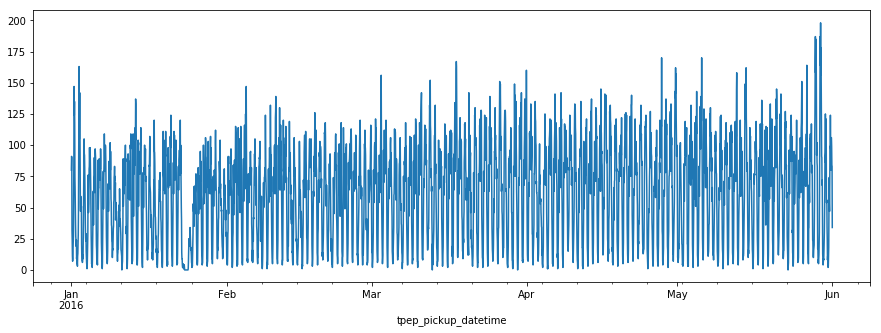

In [13]:
plt.figure(figsize=(15, 5))
data[selected_cell].plot();

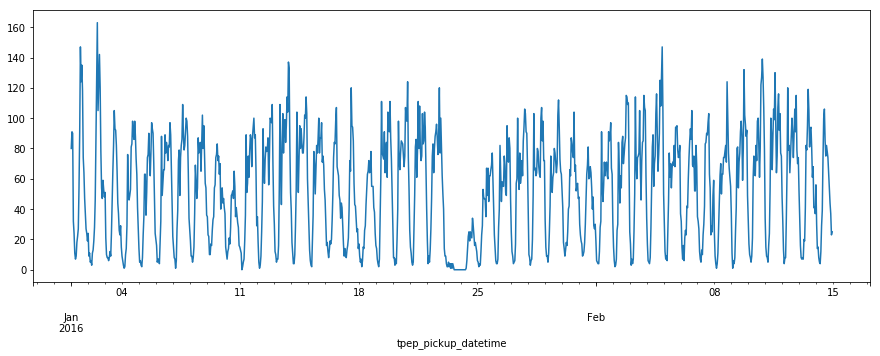

In [14]:
# первые d дней
d = 45
plt.figure(figsize=(15, 5))
data[selected_cell][:(d * 24)].plot();

Явного тренда не видно, сезонность дневая и недельная есть. Поэтому регрессионные признаки добавим только для **сезонности **(**недельной**, дневная будет учтена в ARIMA).

In [15]:
K = 5
week_in_hours = 168 # неделя в часах
for i in range(1, K + 1):
    data['weekly_seasonality_SIN_' + str(i)] = np.sin((np.arange(len(data)) + 1) * 2 * np.pi * i / week_in_hours)
    data['weekly_seasonality_COS_' + str(i)] = np.cos((np.arange(len(data)) + 1) * 2 * np.pi * i / week_in_hours)

Добавим еще **дополнительные признаки - уикенды и праздники**

In [16]:
# уикэнды
data['weekday'] = data.index.weekday
data['weekend'] = data['weekday'].isin([5, 6]).astype(int)

In [17]:
# день недели
for i in range(7):
    data['dayofweek_{}'.format(i)] = data['weekday'].isin([i]).astype(int)

In [18]:
# праздники США
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
calendar = calendar()
holidays = calendar.holidays(start=data.index.min(), end=data.index.max())
data['holiday'] = data.index.isin(holidays).astype(int)

In [19]:
data.head()

,1075,weekly_seasonality_SIN_1,weekly_seasonality_COS_1,weekly_seasonality_SIN_2,weekly_seasonality_COS_2,weekly_seasonality_SIN_3,weekly_seasonality_COS_3,weekly_seasonality_SIN_4,weekly_seasonality_COS_4,weekly_seasonality_SIN_5,...,weekday,weekend,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,holiday
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,80,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,...,4,0,0,0,0,0,1,0,0,1
2016-01-01 01:00:00,91,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,...,4,0,0,0,0,0,1,0,0,0
2016-01-01 02:00:00,90,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,...,4,0,0,0,0,0,1,0,0,0
2016-01-01 03:00:00,32,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,...,4,0,0,0,0,0,1,0,0,0
2016-01-01 04:00:00,24,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,...,4,0,0,0,0,0,1,0,0,0


### 2) Регрессия целевого признака
- Чтобы примерно подобрать порядки дифференцирования ряда в модели **ARIMA**, сделаем регрессию целевого признака — количества поездок — на построенные признаки. 
- Посмотрим на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вряд ли удастся, так что в остатках, скорее всего, будет много интересного, в том числе праздники, аномалии, тренды и многое другое.

Список призднаков для регрессии

In [20]:
feature_list = ['weekly_seasonality_' + SIN_or_COS + '_' + str(i) for i in range(1, K + 1) for SIN_or_COS in ['SIN', 'COS']]
feature_list.extend(['weekend', 'holiday'])
feature_list.extend(['dayofweek_{}'.format(i) for i in range(7)])

2а) **Вариант 1:** Используем просто **linear_model.Ridge**

In [21]:
%%time
reg = linear_model.Ridge()
X = data[feature_list]
y = data[selected_cell]
reg.fit(X, y)

Wall time: 8.99 ms


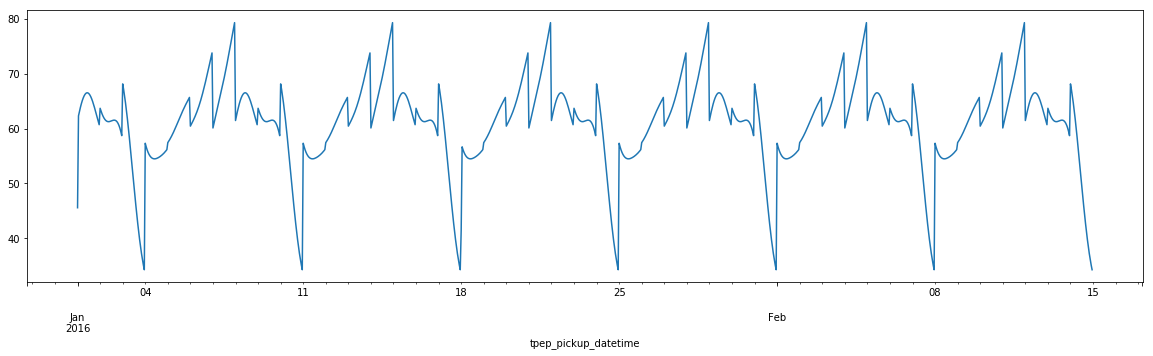

In [22]:
# посмотрим на подобранную регрессионную кривую
plt.figure(figsize=(20, 5))
data['predict'] = reg.predict(X)
data['predict'][:(d * 24)].plot();

Видим ярко выраженную **недельную** сезонность.

Посмотрим на **остатки регрессии**:

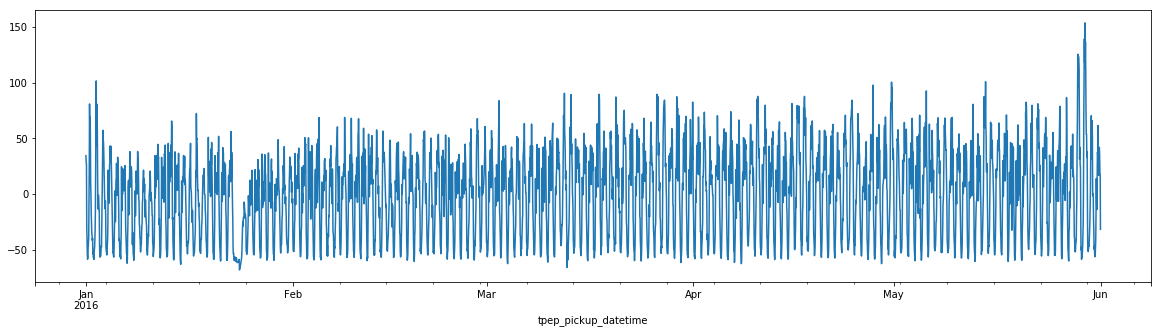

In [23]:
data['resid'] = data[selected_cell] - data['predict']

plt.figure(figsize=(20, 5))
data['resid'].plot();

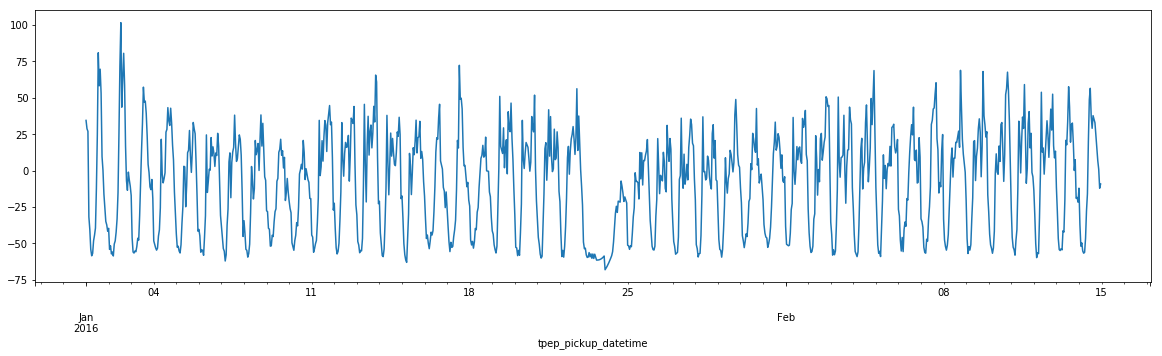

In [24]:
# первые d дней
d = 45
plt.figure(figsize=(20, 5))
data['resid'][:(d * 24)].plot();

In [25]:
reg.coef_

array([ 12.56738181,  20.11666373,   2.22873396,  -2.3760697 ,
        -1.25958075,   2.71489128,   2.01188947,   0.66445325,
         0.55832471,  -0.96573043,  -9.95538515, -15.88249008,
        14.01169872,  15.04067252,   9.49077766,  -4.94091015,
       -23.6468536 , -10.13214772,   0.17676257])

2б) **Вариант 2**: будем использовать **smf.ols**

In [26]:
data['target'] = data[selected_cell] # иначе дает ошибку в ols

In [29]:
m1 = smf.ols('target ~ ' + ' + '.join(feature_list), data=data)
fitted = m1.fit(cov_type='HC1')
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     534.2
Date:                Wed, 02 May 2018   Prob (F-statistic):               0.00
Time:                        12:40:42   Log-Likelihood:                -18463.
No. Observations:                3648   AIC:                         3.696e+04
Df Residuals:                    3630   BIC:                         3.707e+04
Df Model:                          17                                         
Covariance Type:                  HC1                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Посмотрим на остатки

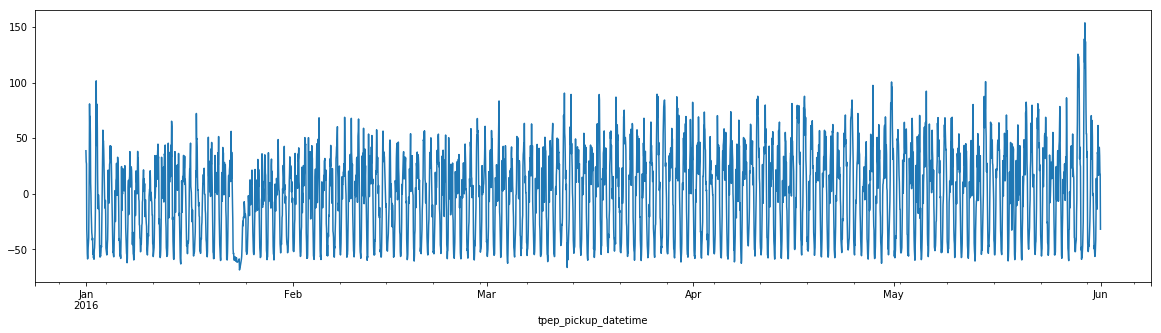

In [30]:
plt.figure(figsize=(20, 5))
fitted.resid.plot();

Кстати, вариант 1 и 2 по регрессии в целом похожи.

Посмотрим на распределение остатков

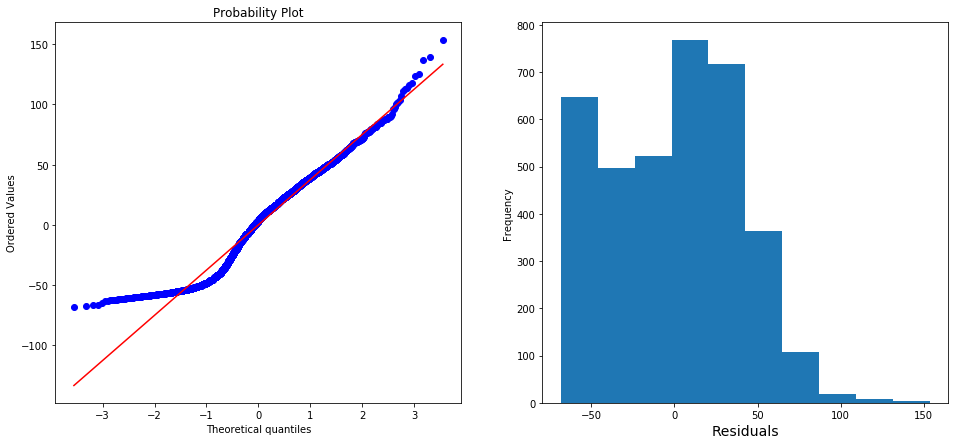

In [31]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=plt)
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14)
plt.show()

### 3) Подбор значения гиперпараметров ARIMA
- Чтобы подобрать значения гиперпараметров ARIMA, попробуем сделать ряд остатков стационарным. 
- Если необходимо, сделаем несколько дифференцирований.

Из-за большого количества аномальных дней (праздники и т.д.) вряд ли  удастся сделать так, что **критерий Дики-Фуллера** не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируемся в первую очередь на результат **STL-декомпозиции**.

Посмотрим на **STL-декомпозицию**

Критерий Дики-Фуллера: p=1.832652e-07


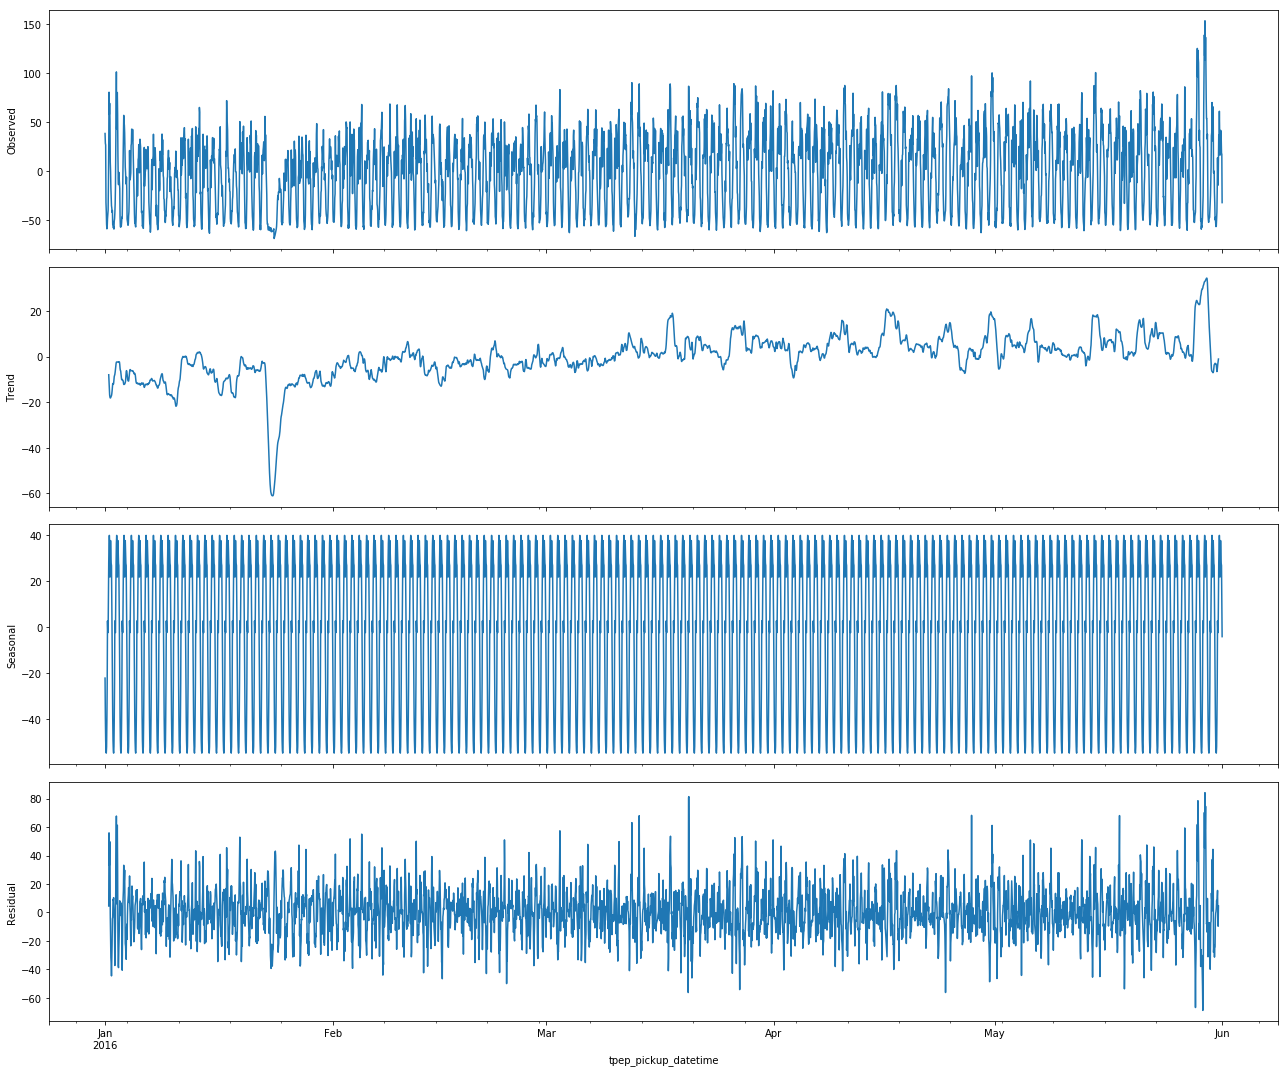

In [32]:
plt.rcParams["figure.figsize"] = (18,15)
sm.tsa.seasonal_decompose(fitted.resid).plot()
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(fitted.resid)[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден небольшой **восходящий тренд**. Попробуем дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=4.048423e-26


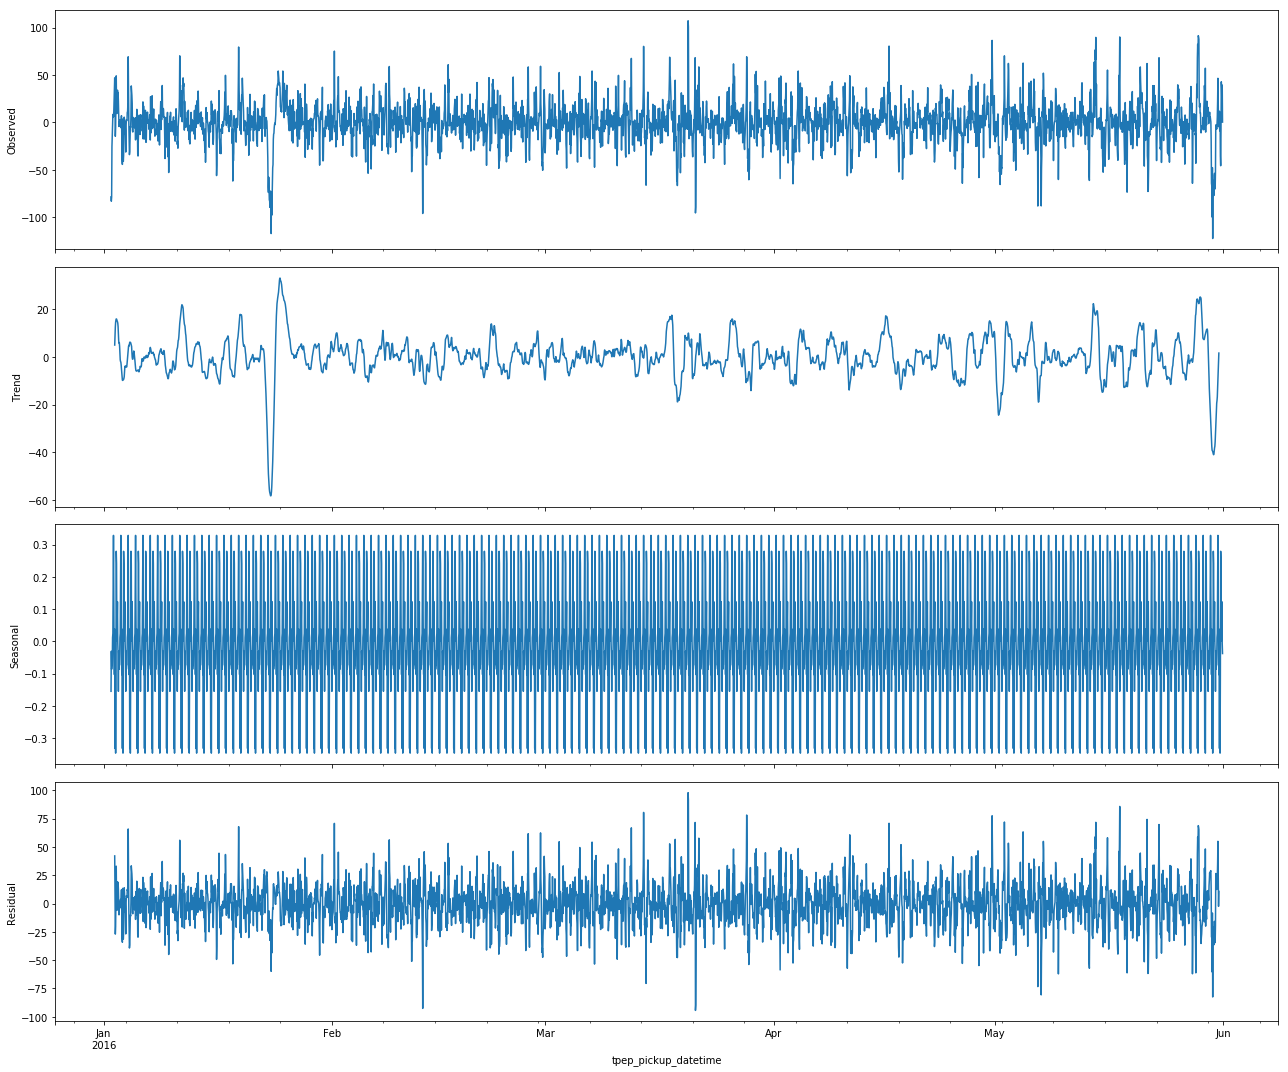

In [33]:
S = 24
data['resid_diff'] = fitted.resid - fitted.resid.shift(S)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data['resid_diff'][(S):]).plot()
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(data['resid_diff'][(S):])[1])

Критерий Дики-Фуллера: p=1.272273e-28


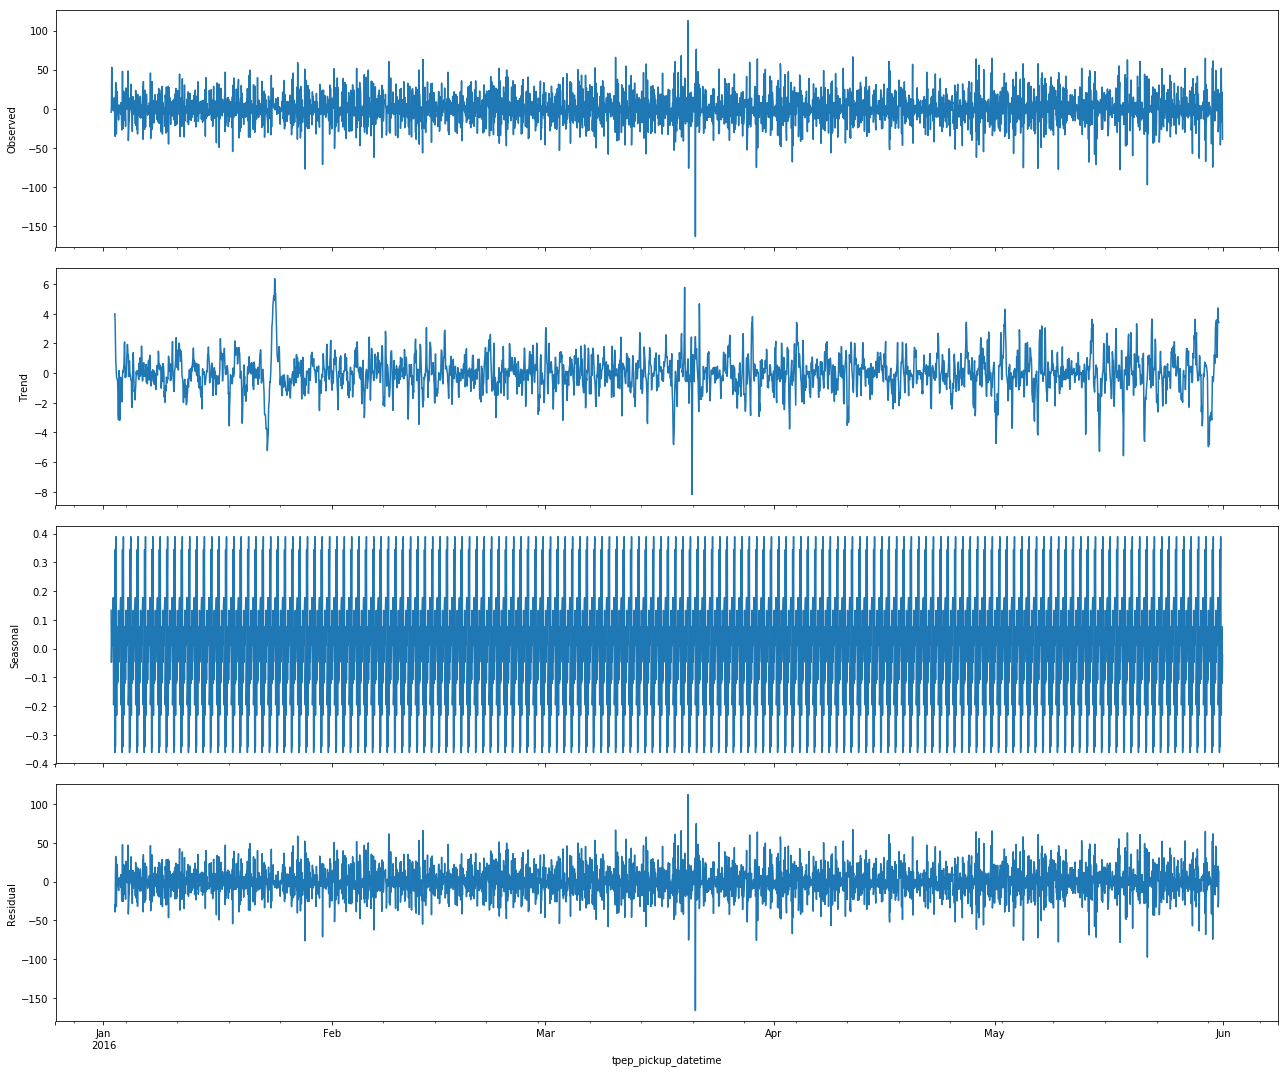

In [34]:
lag = 1
data['resid_diff2'] = data['resid_diff'] - data['resid_diff'].shift(lag)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data['resid_diff2'][(S + lag):]).plot()
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(data['resid_diff2'][(S + lag):])[1])

Визуально тренда уже нет

### 4) p,q,P,Q
- Построим **ACF** и **PACF** полученного ряда остатков с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год) 
- подберем по ним начальные приближения для параметров p,q,P,Q
- Используем эти начальные приближения при переборе моделей **ARIMA** исходного ряда, не забывая подавать функции **SARIMAX** регрессионные признаки в качестве параметра **exog**.

Отметим, что поскольку один отсчет у нас равен 1 часу, то **дневной сезонный период** равен **S = 24** часов-отсчетов. Остальные сезоны (недельный и т.д.) учтем через регрессию.

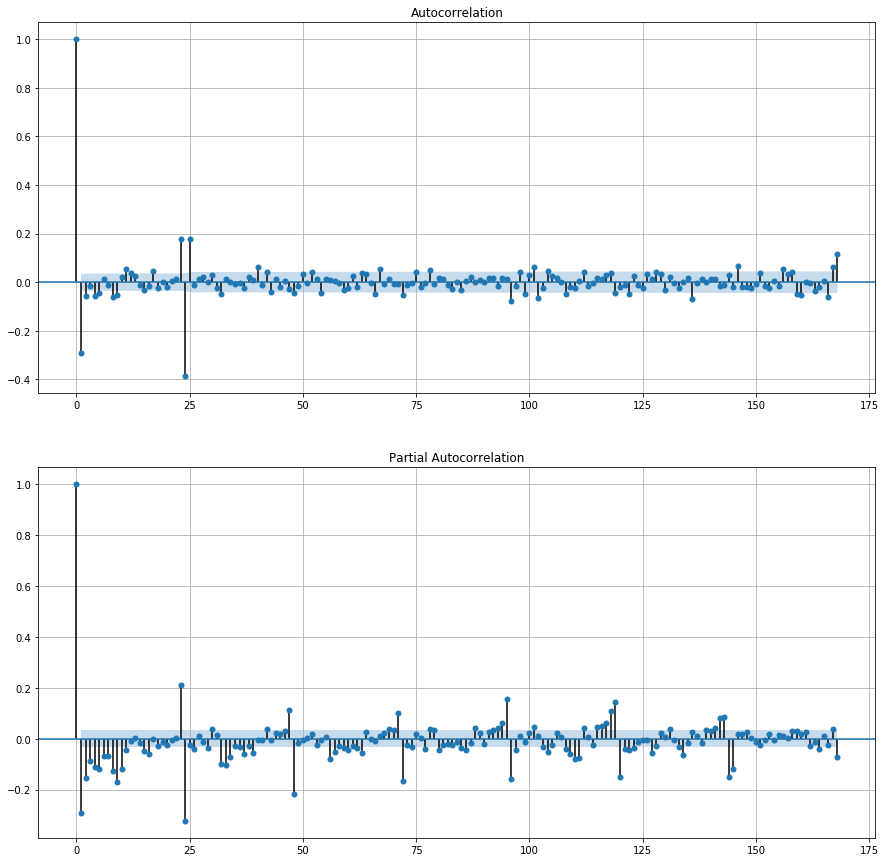

In [35]:
plt.figure(figsize=(15,15))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['resid_diff2'][(S + lag):].values.squeeze(), lags=168, ax=ax)
ax.grid(True)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['resid_diff2'][(S + lag):].values.squeeze(), lags=168, ax=ax)
ax.grid(True)
plt.show()

Начальные приближения:

In [37]:
Q = 1
q = 1
P = 1
p = 2

In [56]:
ps = range(0, p + 1)
d=1
qs = range(0, q + 1)
Ps = range(0, P + 1)
D=1
Qs = range(0, Q + 1)

### 5) Подбор AIC модели
- Выберем оптимальную по AIC модель; 
- построим график исходного ряда и нарисуем поверх предсказания выбранной модели. 

Если модель плохо описывает данные, попробуем увеличить количество синусов и косинусов K или поменять порядки дифференцирования.

In [57]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

In [40]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm_notebook(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog=data[selected_cell], 
                                        exog=data[feature_list], 
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], S)).fit()
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters (ValueError):', param)
        continue
    except LinAlgError:
        print('wrong parameters (LinAlgError):', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))


Wall time: 13min 17s


In [46]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
14  (1, 1, 1, 1)  29371.888983
22  (2, 1, 1, 1)  29383.281778
12  (1, 1, 0, 1)  29500.324924
20  (2, 1, 0, 1)  29502.080240
6   (0, 1, 1, 1)  29876.528276


Сохраним результат

In [42]:
result_table.to_csv(os.path.join(path_to_data, 'result_table_v3.csv'))

## Посмотрим, насколько точно модель описывает данные.

Построим оригинальные данные и предсказание:

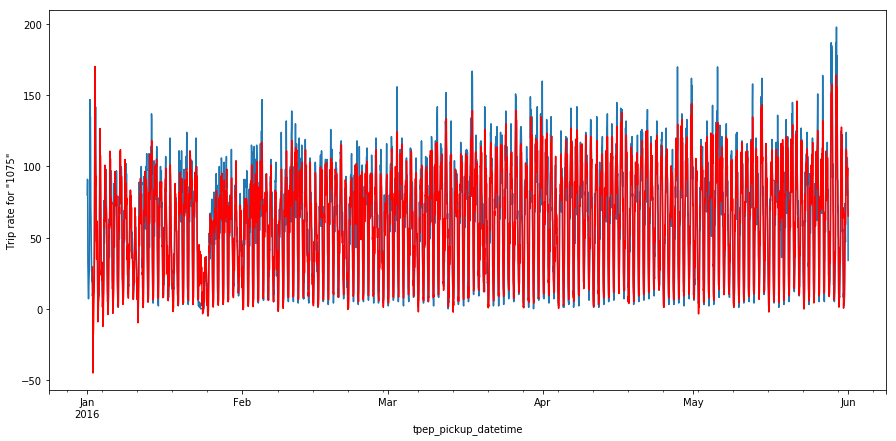

In [43]:
data['model'] = best_model.fittedvalues
plt.figure(figsize=(15,7))
data[selected_cell].plot()
data['model'][(S + lag):].plot(color='r')
plt.ylabel('Trip rate for "1075"')
plt.show()

Посмотрим на те же оригинальные и предсказанные данные, но на 1000 последних отсчетах (для наглядности):

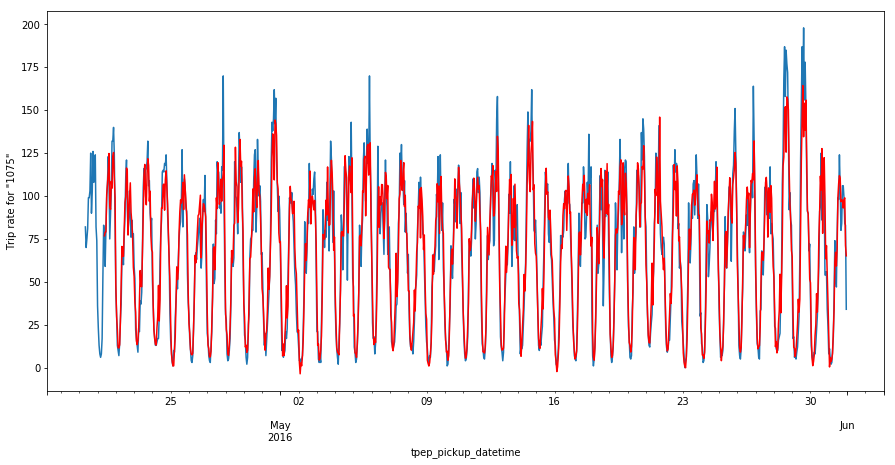

In [44]:
data['model'] = best_model.fittedvalues
plt.figure(figsize=(15,7))
data[selected_cell][-1000:].plot()
data['model'][(-1000 + S + lag):].plot(color='r')
plt.ylabel('Trip rate for "1075"')
plt.show()

## Прогноз

In [45]:
n = 5 # глубина прогнозирования, дней
data_end = data.index[-1].strftime('%Y-%m-%d %H:%M:%S') # финальная дата, от которой начинается прогнозирование

In [46]:
# формируем временной ряд для прогноза 
start_future = data_end
end_future = (datetime.strptime(start_future, '%Y-%m-%d %H:%M:%S') + n * Day()).strftime('%Y-%m-%d %H:%M:%S') # конечная дата
date_list = pd.date_range(start_future, end_future, freq='H') # временной ряд для прогноза 

In [51]:
data2 = data[[selected_cell]]
future = pd.DataFrame(index=date_list, columns= data2.columns) # заготовка для прогноза

# делаем exog-аргумент для прогноза (регрессионные признаки для прогноза)
# K = 5
# week_in_hours = 168 # неделя в часах
for i in range(1, K + 1):
    future['weekly_seasonality_SIN_' + str(i)] = np.sin(np.arange(len(data), len(data) + len(date_list)) 
                                                        * 2 * np.pi * i / week_in_hours)
    future['weekly_seasonality_COS_' + str(i)] = np.cos(np.arange(len(data), len(data) + len(date_list)) 
                                                        * 2 * np.pi * i / week_in_hours)
    
# уикэнды
future['weekday'] = future.index.weekday
future['weekend'] = future['weekday'].isin([5, 6]).astype(int)

# день недели
for i in range(7):
    future['dayofweek_{}'.format(i)] = future['weekday'].isin([i]).astype(int)

# праздники США
# from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
# calendar = calendar()
holidays = calendar.holidays(start=future.index.min(), end=future.index.max())
future['holiday'] = future.index.isin(holidays).astype(int)

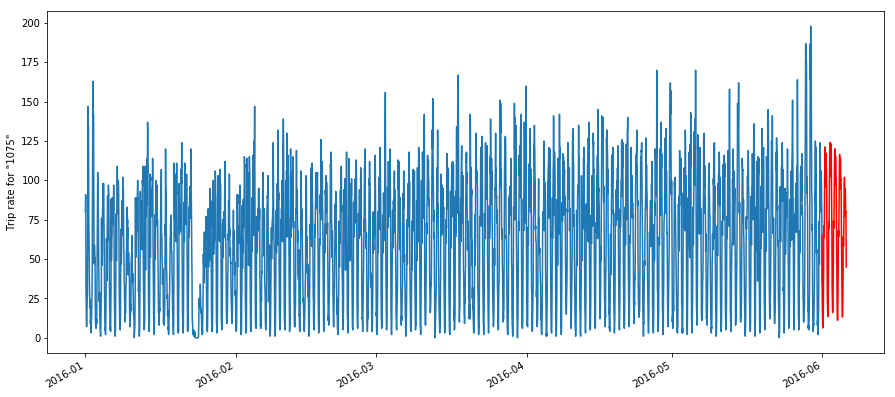

In [52]:
data2 = pd.concat([data2, future])

start = len(data) - 1
end = start + len(date_list)

exog_future = future[feature_list][-len(date_list):]

data2['forecast'] = best_model.predict(start=start, end=end, exog=exog_future)

plt.figure(figsize=(15,7))
data2[selected_cell].plot()
data2['forecast'].plot(color='r')
plt.ylabel('Trip rate for "1075"')
plt.show()

Выведем для наглядности **только "хвост" оригинального ряда** с прогнозом

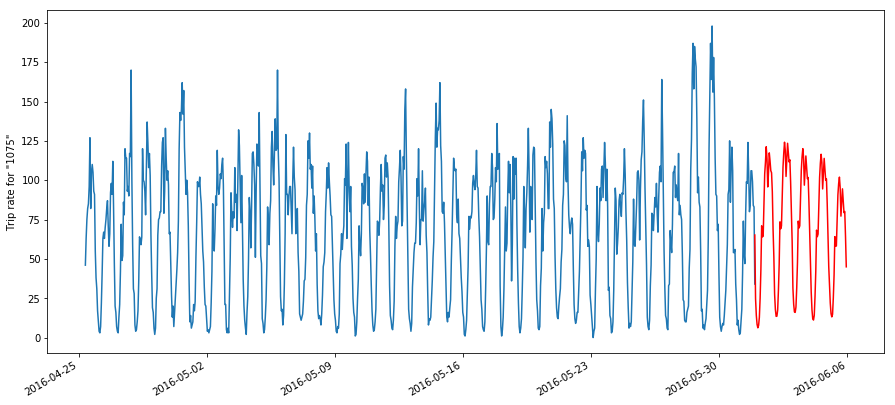

In [53]:
plt.figure(figsize=(15,7))
data2[selected_cell][-1000:].plot()
data2.forecast.plot(color='r')
plt.ylabel('Trip rate for "1075"')
plt.show()

## <center>Проанализируем качество построенной модели

In [54]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                               1075   No. Observations:                 3648
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -14648.076
Date:                            Wed, 02 May 2018   AIC                          29344.152
Time:                                    13:11:00   BIC                          29492.999
Sample:                                01-01-2016   HQIC                         29397.162
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
weekly_seasonality_SIN_1     7.1033      2.885      2.462      0.014       1.448      

Посмотрим на остатки визуально:

Критерий Стьюдента: p=0.401751
Критерий Дики-Фуллера: p=0.000000


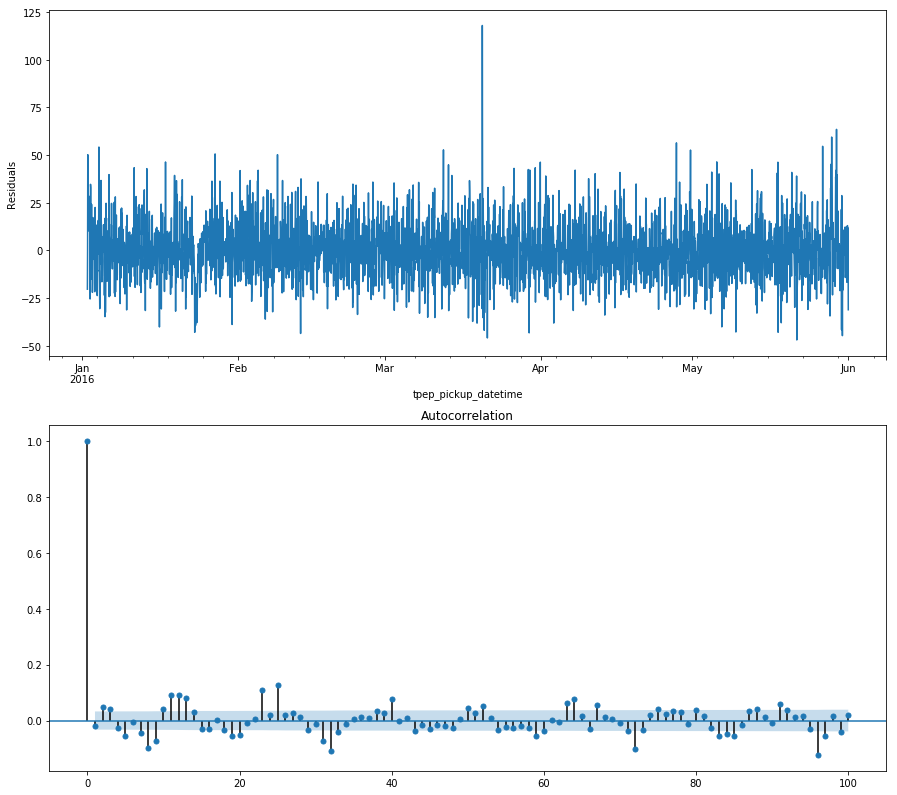

In [55]:
plt.figure(figsize=(15,14))
plt.subplot(211)
best_model.resid[(S + lag):].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[(S + lag):].values.squeeze(), lags=100, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[(S + lag):], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[(S + lag):])[1])

## ВЫВОДЫ по анализу ОСТАТКОВ:    
- Остатки **несмещены** (подтверждается критерием Стьюдента) 
- **стационарны** (подтверждается критерием Дики-Фуллера и визуально), 
- **неавтокоррелированность** под вопросом (критерий Льюнга-Бокса меньше порога 0.05 и на коррелограмме есть выходы за поле отсутствия значимости). НО, поскольку эти выходы на коррелограмме **незначительные**, можем считать отсутствие автокоррелированности остатков **удовлетворительной**.   

**ИТОГО**, делаем вывод: модель **удовлетворительная**.   

## ВЫВОДЫ по анализу графиков построенных ПРОГНОЗОВ:   
- сезонность (дневную и недельную) описывает хорошо
- провал в конце января уловила
- положения пиков улавливает хорошо
- тенденцию на увеличение и уменьшение пиков улавливает (это как раз недельная сезонность)
- а вот верхнее значение пиков часто занижает

## ИТОГО: модель можно считать удовлетворительной, для тонкой настройки больше ресурсов